In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import load_model

In [2]:
train_data_dir= "/kaggle/input/brain-tumor-mri-dataset/Training"
test_data_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

In [3]:
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
X_train, X_valid = train_test_split(train_df,  train_size=0.8 , shuffle= True, random_state= 123)

In [5]:
X_train.head()

,filepaths,labels
2730,/kaggle/input/brain-tumor-mri-dataset/Training...,notumor
4748,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
4811,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
3789,/kaggle/input/brain-tumor-mri-dataset/Training...,meningioma
1672,/kaggle/input/brain-tumor-mri-dataset/Training...,notumor


In [6]:
train_data_dir= "/kaggle/input/brain-tumor-mri-dataset/Training"
test_data_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

IMAGE_SIZE =(256,256)
BATCH_SIZE = 32

# Training and validation datasets
X_train = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,  # Use 20% of the data for validation
    subset="training",  # Specify the subset
    seed=42,  # Ensure reproducibility
    image_size=IMAGE_SIZE,  # Resize images to 128x128
    batch_size=BATCH_SIZE  # Batch size
)


X_val = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

X_test = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    shuffle =False,
    seed=42,  # Ensure reproducibility
    image_size=IMAGE_SIZE,  # Resize images to 128x128
    batch_size=BATCH_SIZE  # Batch size
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [7]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

# Apply normalization to transform images into float32
X_train_normalized = X_train.map(normalize_img)
X_val_normalized = X_val.map(normalize_img)

#Apply MRI-specific normalization:
#def mri_normalize(image, label):
#    """Applies MRI-specific normalization."""
#    # Z-score normalization
#    mean = tf.reduce_mean(image)
#    std = tf.math.reduce_std(image)
#    normalized_image = (image - mean) / std
#    return normalized_image, label

#X_train_normalized = X_train_normalized.map(mri_normalize)
#X_val_normalized = X_val_normalized.map(mri_normalize)

Original Data:


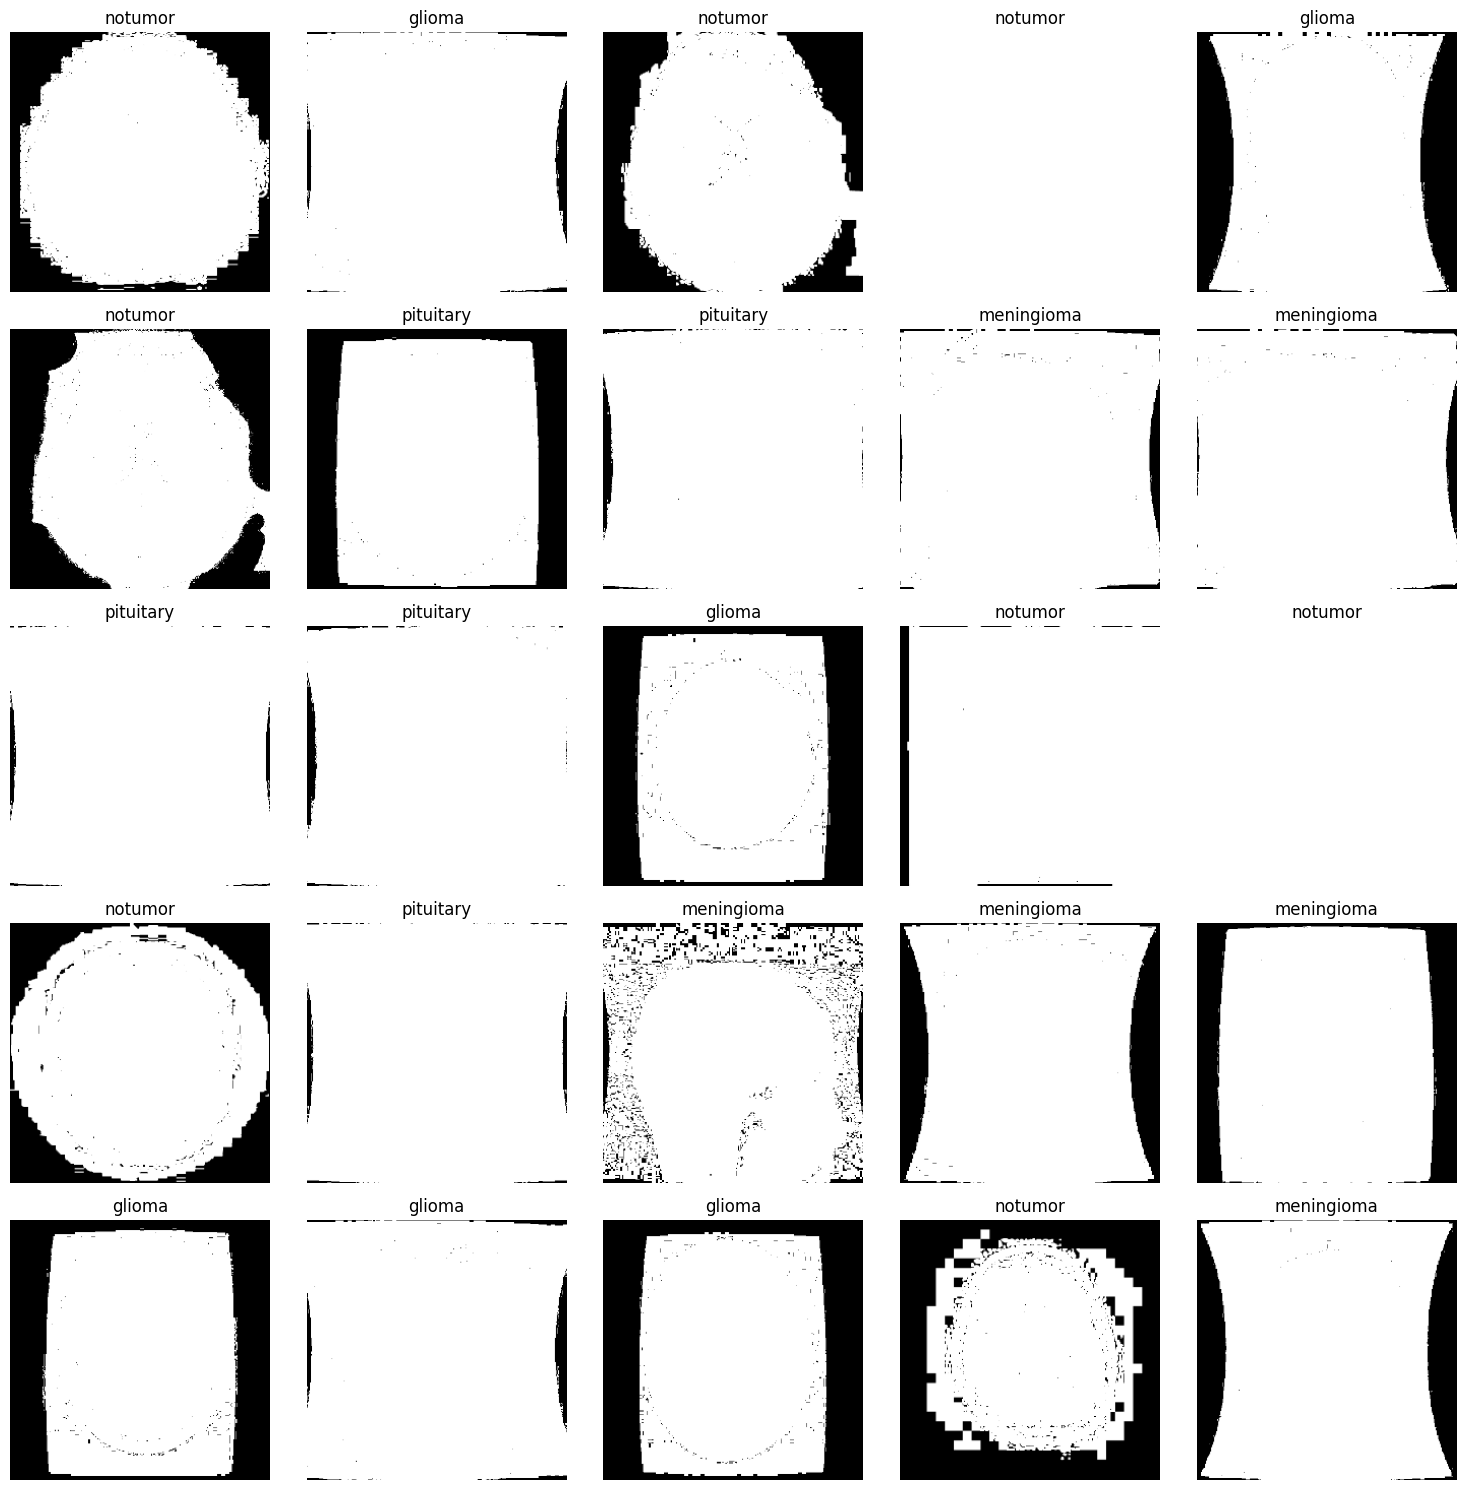

Normalized Data:


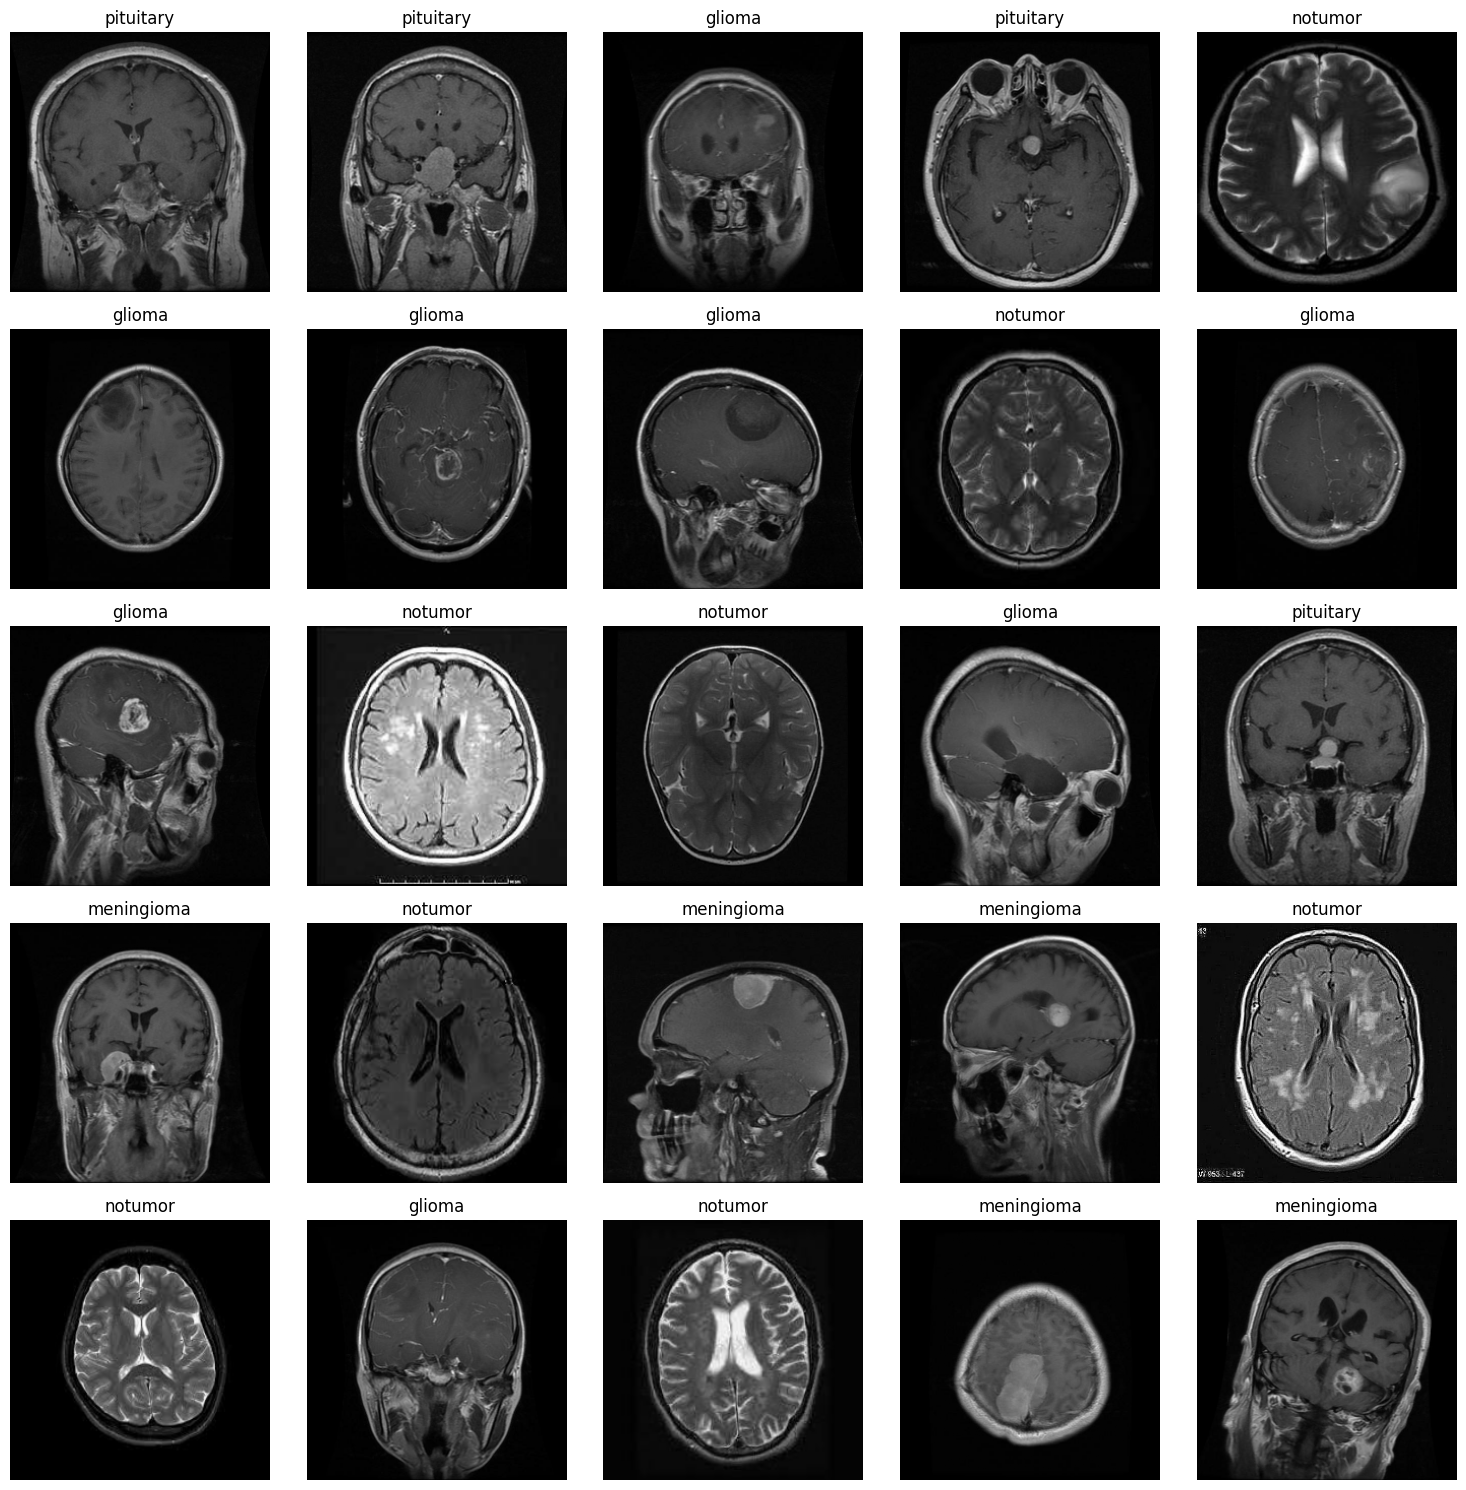

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def plot_images_with_labels(dataset, class_names, num_images=25, figsize=(15, 15)):
    plt.figure(figsize=figsize)
    for images, labels in dataset.take(1):
        for i in range(min(num_images, len(images))):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("float32"), cmap='gray')
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Get class names from the dataset
class_names = X_train.class_names

# Plot original data with labels
print("Original Data:")
plot_images_with_labels(X_train, class_names)

# Plot normalized data with labels
print("Normalized Data:")
plot_images_with_labels(X_train_normalized, class_names)

In [ ]:
import tensorflow as tf

# Define the number of classes
num_classes = len(class_names)  # Replace with the actual number of classes

def one_hot_encode(image, label):
    return image, tf.one_hot(label, depth=num_classes)

X_train_encoded = X_train_normalized.map(one_hot_encode)
X_val_encoded = X_val_normalized.map(one_hot_encode)

# Shuffle and batch the datasets
#X_train_encoded = X_train_encoded.shuffle(buffer_size=500).batch(BATCH_SIZE)
#X_val_encoded = X_val_encoded.batch(BATCH_SIZE)

# Debug the dataset shapes
for image_batch, label_batch in X_train_encoded.take(1):
    print("Image batch shape:", image_batch.shape)  # Should be (batch_size, 256, 256, 3)
    print("Label batch shape:", label_batch.shape)  # Should be (batch_size, num_classes)


# Define the model

# Define the regularizer (choose one)
l1_regularizer = regularizers.L1(1e-5)      # L1 Regularization
l2_regularizer = regularizers.L2(1e-4)      # L2 Regularization
l1_l2_regularizer = regularizers.L1L2(l1=1e-5, l2=1e-4)  # L1 + L2 Regularization

# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(256, 256, 3)),

    # Convolutional layers with regularization
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu',
                           kernel_regularizer=l1_l2_regularizer),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu',
                           kernel_regularizer=l1_l2_regularizer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu',
                           kernel_regularizer=l1_l2_regularizer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu',
                           kernel_regularizer=l1_l2_regularizer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu',
                           kernel_regularizer=l1_l2_regularizer),
    tf.keras.layers.BatchNormalization(),

    # Fully connected layers with regularization
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax',
                          kernel_regularizer=l1_l2_regularizer)
])

# Compile and train the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

history = model.fit(
    X_train_encoded,
    validation_data=X_val_encoded,
    epochs=100,
    batch_size=32
)

Image batch shape: (32, 256, 256, 3)
Label batch shape: (32, 4)
Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 224ms/step - accuracy: 0.6236 - auc_1: 0.8600 - loss: 1.2893 - precision_1: 0.8221 - recall_1: 0.4110 - val_accuracy: 0.2811 - val_auc_1: 0.5572 - val_loss: 2.1317 - val_precision_1: 0.4094 - val_recall_1: 0.1979
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.7648 - auc_1: 0.9367 - loss: 1.0103 - precision_1: 0.8393 - recall_1: 0.6669 - val_accuracy: 0.2636 - val_auc_1: 0.5597 - val_loss: 4.5170 - val_precision_1: 0.2636 - val_recall_1: 0.2636
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.8073 - auc_1: 0.9536 - loss: 0.9153 - precision_1: 0.8509 - recall_1: 0.7347 - val_accuracy: 0.2662 - val_auc_1: 0.5856 - val_loss: 5.3423 - val_precision_1: 0.2669 - val_recall_1: 0.2662
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.8301 - auc_1: 0.9636 - loss: 0.8524 - precision_1: 0.8654 - recall_1: 0.7775 - val_accuracy:

In [35]:
# Print model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,390,734 (24.38 MB)

 Trainable params: 2,129,604 (8.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 4,259,210 (16.25 MB)

In [36]:
print(history.history.keys())

dict_keys(['accuracy', 'auc_1', 'loss', 'precision_1', 'recall_1', 'val_accuracy', 'val_auc_1', 'val_loss', 'val_precision_1', 'val_recall_1'])


In [37]:
# Find the index of the best validation accuracy
best_epoch_index = np.argmax(history.history['val_accuracy'])

print(f"Best epoch (index) based on validation accuracy: {best_epoch_index}")

Best epoch (index) based on validation accuracy: 73


In [39]:
# Optionally, print specific metrics like accuracy, loss, and AUC
print("\nSpecific Metrics (Training & Validation):")
print(f"Training Accuracy: {history.history['accuracy'][best_epoch_index]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][best_epoch_index]}")
print(f"Training Loss: {history.history['loss'][best_epoch_index]}")
print(f"Validation Loss: {history.history['val_loss'][best_epoch_index]}")
print(f"Training Precision: {history.history['precision_1'][best_epoch_index]}")
print(f"Validation Precision: {history.history['val_precision_1'][best_epoch_index]}")
print(f"Training Recall: {history.history['recall_1'][best_epoch_index]}")
print(f"Validation Recall: {history.history['val_recall_1'][best_epoch_index]}")
print(f"Training AUC: {history.history['auc_1'][best_epoch_index]}")
print(f"Validation AUC: {history.history['val_auc_1'][best_epoch_index]}")


Specific Metrics (Training & Validation):
Training Accuracy: 0.9986870884895325
Validation Accuracy: 0.9667250514030457
Training Loss: 0.35540470480918884
Validation Loss: 0.4533262252807617
Training Precision: 0.9986870884895325
Validation Precision: 0.9675153493881226
Training Recall: 0.9986870884895325
Validation Recall: 0.9649737477302551
Training AUC: 0.999997615814209
Validation AUC: 0.9963495135307312


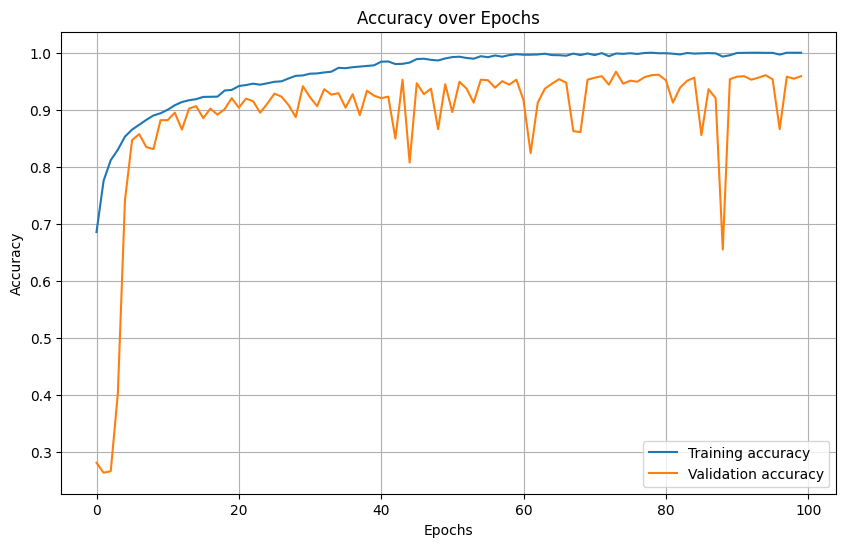

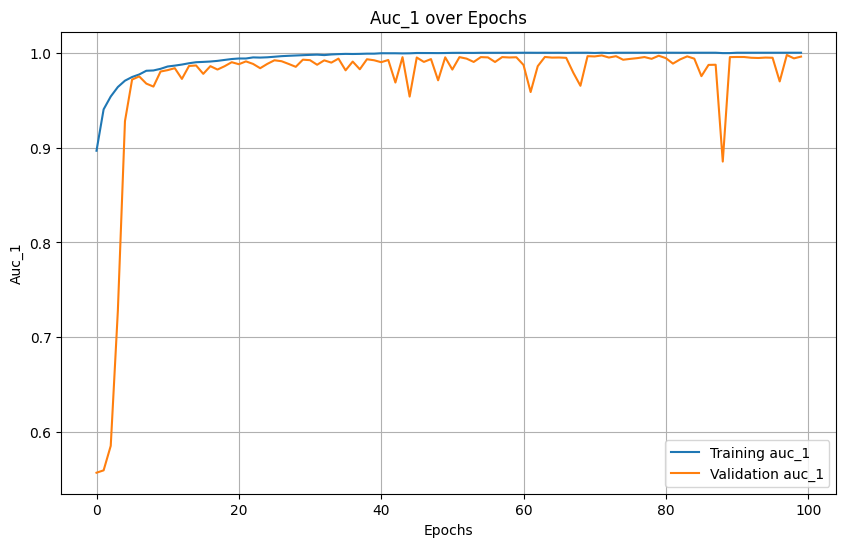

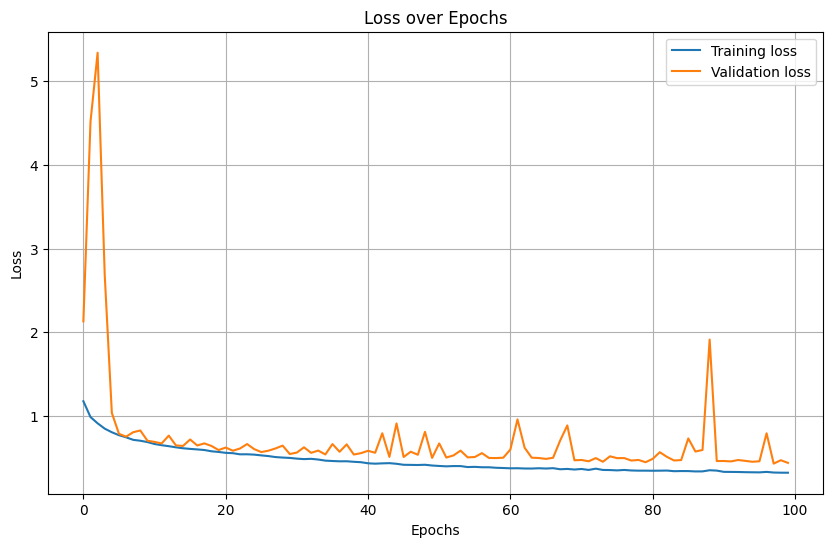

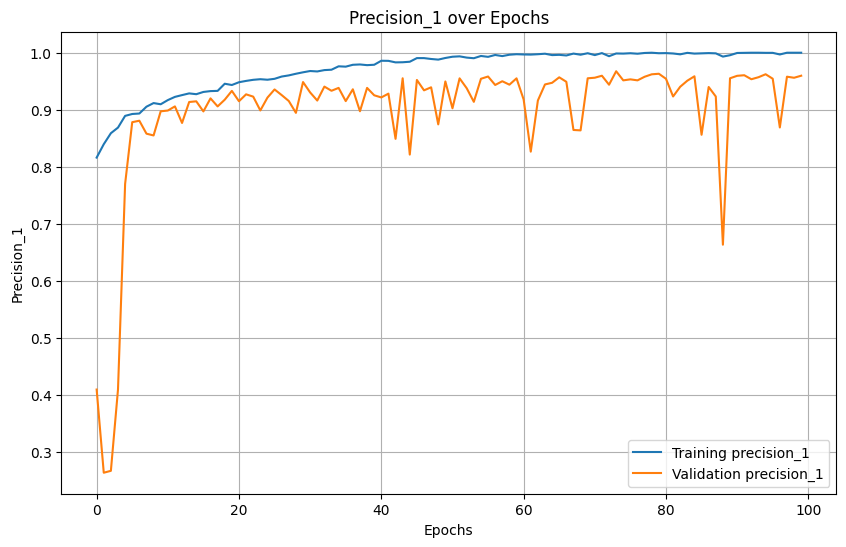

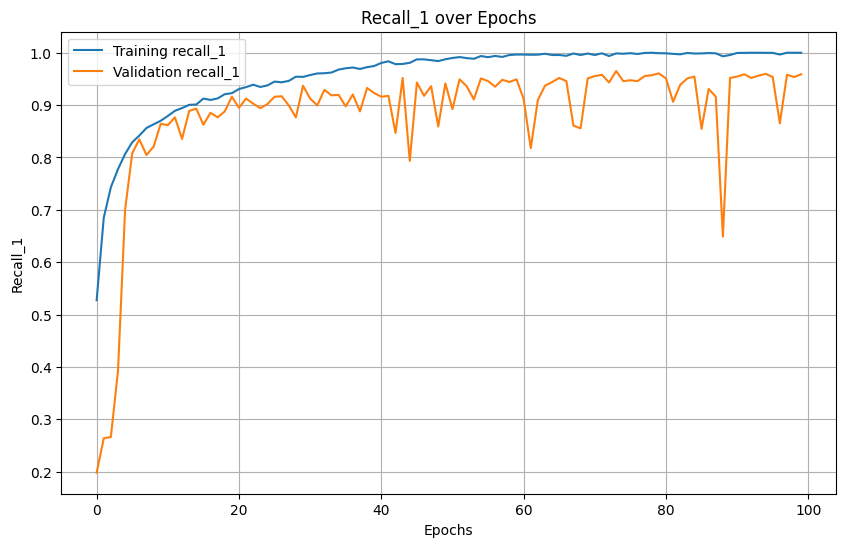

In [41]:
# Define the metrics to plot
metrics = ['accuracy', 'auc_1', 'loss', 'precision_1', 'recall_1']

# Plot each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(f'{metric.capitalize()} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:
# Set up directories for saving the model and TensorBoard logs
checkpoint_dir = './checkpoints'
tensorboard_log_dir = './logs'

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(tensorboard_log_dir, exist_ok=True)

In [19]:
callbacks = [
    # Save the model with the minimum valdiation loss
    ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
                    monitor='val_loss', mode='min', save_best_only=True, verbose=1),

    # Early stopping to stop training when validation loss stops decreasing
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),

    # Reduce learning rate when the validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1),

    # TensorBoard logging
    TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1, write_images=True)
]

In [25]:
# Training the model with callbacks and storing the training history
history = model.fit(
    X_train_encoded,  # Training data generator or dataset
    epochs=100,
    batch_size=32,
    validation_data=X_val_encoded,  # Validation data generator or dataset
    callbacks=callbacks
)

Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9968 - auc: 0.9999 - loss: 0.3343 - precision: 0.9969 - recall: 0.9968
Epoch 1: val_loss did not improve from 0.43616
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.9968 - auc: 0.9999 - loss: 0.3344 - precision: 0.9969 - recall: 0.9968 - val_accuracy: 0.6935 - val_auc: 0.8971 - val_loss: 1.4929 - val_precision: 0.6945 - val_recall: 0.6909 - learning_rate: 1.0000e-05
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9974 - auc: 1.0000 - loss: 0.3351 - precision: 0.9977 - recall: 0.9974
Epoch 2: val_loss improved from 0.43616 to 0.41715, saving model to ./checkpoints/best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.9974 - auc: 1.0000 - loss: 0.3351 - precision: 0.9977 - recall: 0.9974 - val_accuracy: 0.9641 - val_auc: 0.9973 - val_loss: 0.4171 - val_precision: 0.9641 - val_recall: 0.9632 - learning_rate: 1.0000e-05
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/ste

In [26]:
# Find the index of the best validation accuracy
best_epoch_index = np.argmax(history.history['val_accuracy'])

print(f"Best epoch (index) based on validation accuracy: {best_epoch_index}")

Best epoch (index) based on validation accuracy: 1


In [27]:
print(history.history.keys())

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])


In [28]:
# Optionally, print specific metrics like accuracy, loss, and AUC
print("\nSpecific Metrics (Training & Validation):")
print(f"Training Accuracy: {history.history['accuracy'][best_epoch_index]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][best_epoch_index]}")
print(f"Training Loss: {history.history['loss'][best_epoch_index]}")
print(f"Validation Loss: {history.history['val_loss'][best_epoch_index]}")
print(f"Training Precision: {history.history['precision'][best_epoch_index]}")
print(f"Validation Precision: {history.history['val_precision'][best_epoch_index]}")
print(f"Training Recall: {history.history['recall'][best_epoch_index]}")
print(f"Validation Recall: {history.history['val_recall'][best_epoch_index]}")
print(f"Training AUC: {history.history['auc'][best_epoch_index]}")
print(f"Validation AUC: {history.history['val_auc'][best_epoch_index]}")


Specific Metrics (Training & Validation):
Training Accuracy: 0.998468279838562
Validation Accuracy: 0.9640980958938599
Training Loss: 0.33021897077560425
Validation Loss: 0.4171455502510071
Training Precision: 0.9986867904663086
Validation Precision: 0.9640666246414185
Training Recall: 0.998468279838562
Validation Recall: 0.9632224440574646
Training AUC: 0.9999954104423523
Validation AUC: 0.9973382949829102


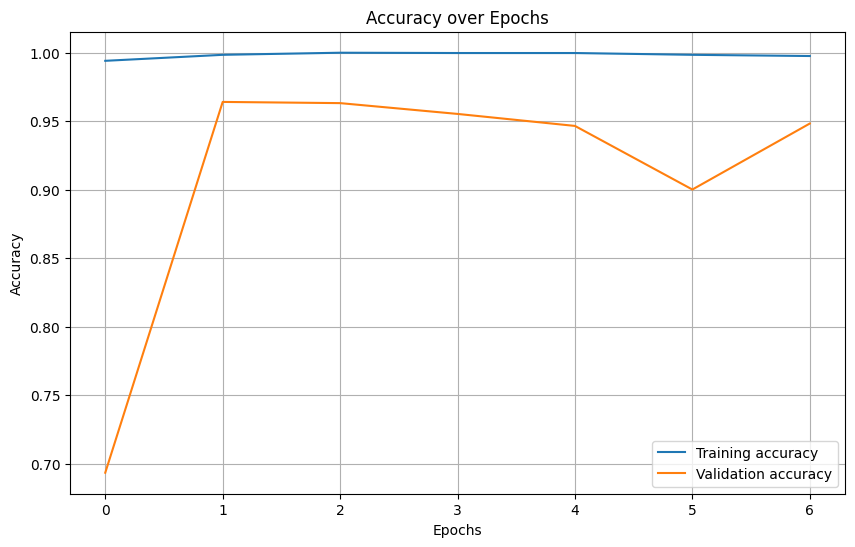

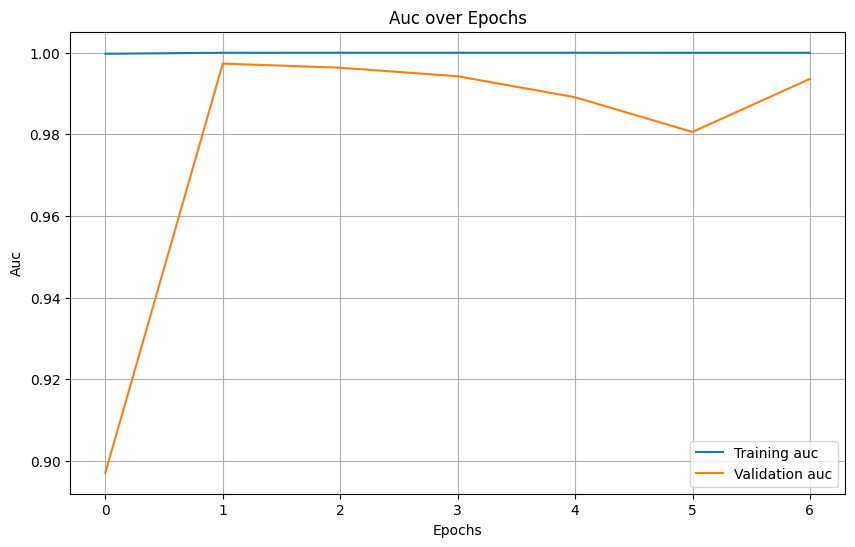

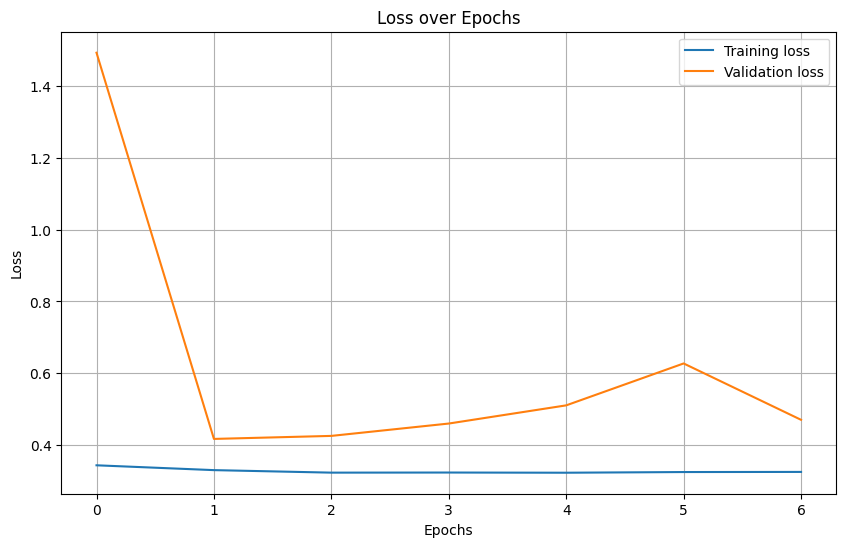

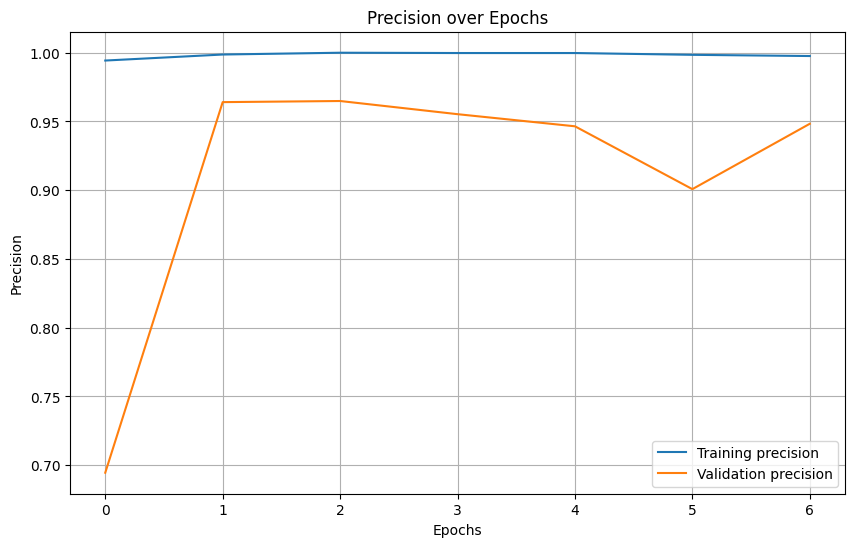

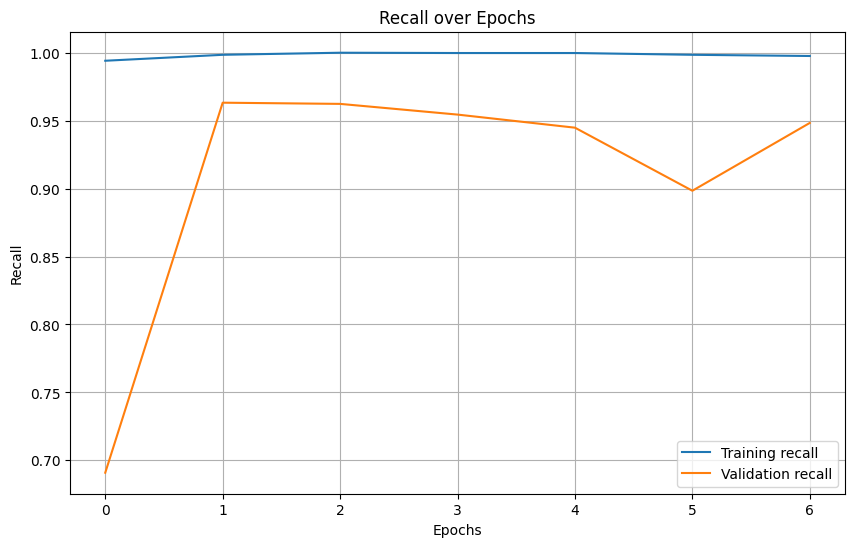

In [29]:
# Define the metrics to plot
metrics = ['accuracy', 'auc', 'loss', 'precision', 'recall']

# Plot each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(f'{metric.capitalize()} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

In [30]:
# Load the best model
best_model_path = os.path.join(checkpoint_dir, 'partial_checkpoint.keras')
best_model = load_model(best_model_path)

# Evaluate on test data
test_loss, test_accuracy, test_auc, test_precision, test_recall = best_model.evaluate(X_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

ValueError: File not found: filepath=./checkpoints/partial_checkpoint.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
from visualkeras import layered_view
from collections import defaultdict

In [31]:
# Customize the color map for different layers
color_map = defaultdict(dict)
# Custom pastel colors
color_map[layers.Conv2D]['fill'] = "#A4D8D0"  # Light Teal (soft and calming)
color_map[layers.BatchNormalization]['fill'] = "#B497D7"  # Soft Lavender (smooth transition)
color_map[layers.MaxPooling2D]['fill'] = "#FFBC80"  # Light Orange (bright accent)
color_map[layers.GlobalAveragePooling2D]['fill'] = "#F9E59E"  # Soft Yellow (light and airy)
color_map[layers.Dropout]['fill'] = "#F7B7A3"  # Soft Peach (warm, welcoming)
color_map[layers.Dense]['fill'] = "#F1A7B7"  # Muted Coral (vibrant yet soft)

# Visualize the model architecture with the custom color map
img = layered_view(best_model, legend=True, max_xy=300, color_map=color_map)

# Display the image
plt.imshow(img)
plt.axis('off')  # Remove axis for cleaner display
plt.show()

NameError: name 'defaultdict' is not defined

In [ ]:
# Get the true labels (y_test) from the test generator
y_test = X_test.labels

In [ ]:
# Get the predicted probabilities for the test set
y_pred_proba = best_model.predict(X_test, verbose=1)

# Convert predicted probabilities to predicted class labels
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# Proceed to calculate metrics like the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=X_test.class_indices.keys(), yticklabels=X_test.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Fetch a batch of images and labels for visualization
test_images, test_labels = next(X_test)

# Predict on the batch
batch_predictions = best_model.predict(test_images)
batch_predicted_classes = np.argmax(batch_predictions, axis=1)

# Visualize
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i], cmap='gray')
    true_label = class_labels[np.argmax(test_labels[i])]
    predicted_label = class_labels[batch_predicted_classes[i]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()